In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 20})
output_path = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/generated_images/eda'

In [2]:
def create_image_df(input_dir):
    data = []
    
    for folder_name in os.listdir(input_dir):
        if folder_name.startswith('.'):
            continue
            
        folder_path = os.path.join(input_dir, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.tif'):
                    img_path = os.path.join(folder_path, file_name)
                    img = Image.open(img_path)
                    img_array = np.array(img.convert("RGB"))

                    #Source: https://www.researchpublish.com/upload/book/Luminance%20Based%20Conversion%20of%20Gray-2149.pdf                    
                    gray_img = (0.2989 * img_array[:,:,0] + 
                                0.5870 * img_array[:,:,1] + 
                                0.1140 * img_array[:,:,2])
                    
                    #Source: https://www.biorxiv.org/content/10.1101/2021.07.08.451706v1.full
                    mean_luminance = gray_img.mean()
                    N = gray_img.size
                    rms_contrast = np.sqrt(1/(N-1) * np.sum((gray_img - mean_luminance)**2))
                    
                    
                    
                    data.append({
                        'class': folder_name,
                        'raw_values': img_array,
                        'R_mean': img_array[:,:,0].mean(),  
                        'G_mean': img_array[:,:,1].mean(),  
                        'B_mean': img_array[:,:,2].mean(),
                        'brightness': mean_luminance,
                        'contrast': rms_contrast,
                    })
    
    return pd.DataFrame(data)


input_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/unprocessed'
df = create_image_df(input_dir)

In [3]:
df.head()

class                                         raw_values      R_mean  \
0  Land  [[[108, 92, 72], [107, 90, 72], [114, 97, 76],...  121.151810   
1  Land  [[[44, 52, 44], [50, 59, 50], [50, 61, 48], [5...  102.716217   
2  Land  [[[40, 32, 20], [41, 33, 21], [40, 34, 23], [4...   71.823227   
3  Land  [[[139, 105, 86], [144, 107, 86], [154, 115, 9...  116.124161   
4  Land  [[[40, 39, 37], [32, 33, 30], [57, 56, 52], [5...   25.400772   

       G_mean     B_mean  brightness   contrast  
0  106.710724  81.263977  108.115564  30.676389  
1  103.100327  77.700775  100.079657  36.873330  
2   60.321060  41.759598   61.637019  24.826353  
3   88.176605  66.525665   94.053105  26.912188  
4   22.341843  20.843643   23.083128  29.807160

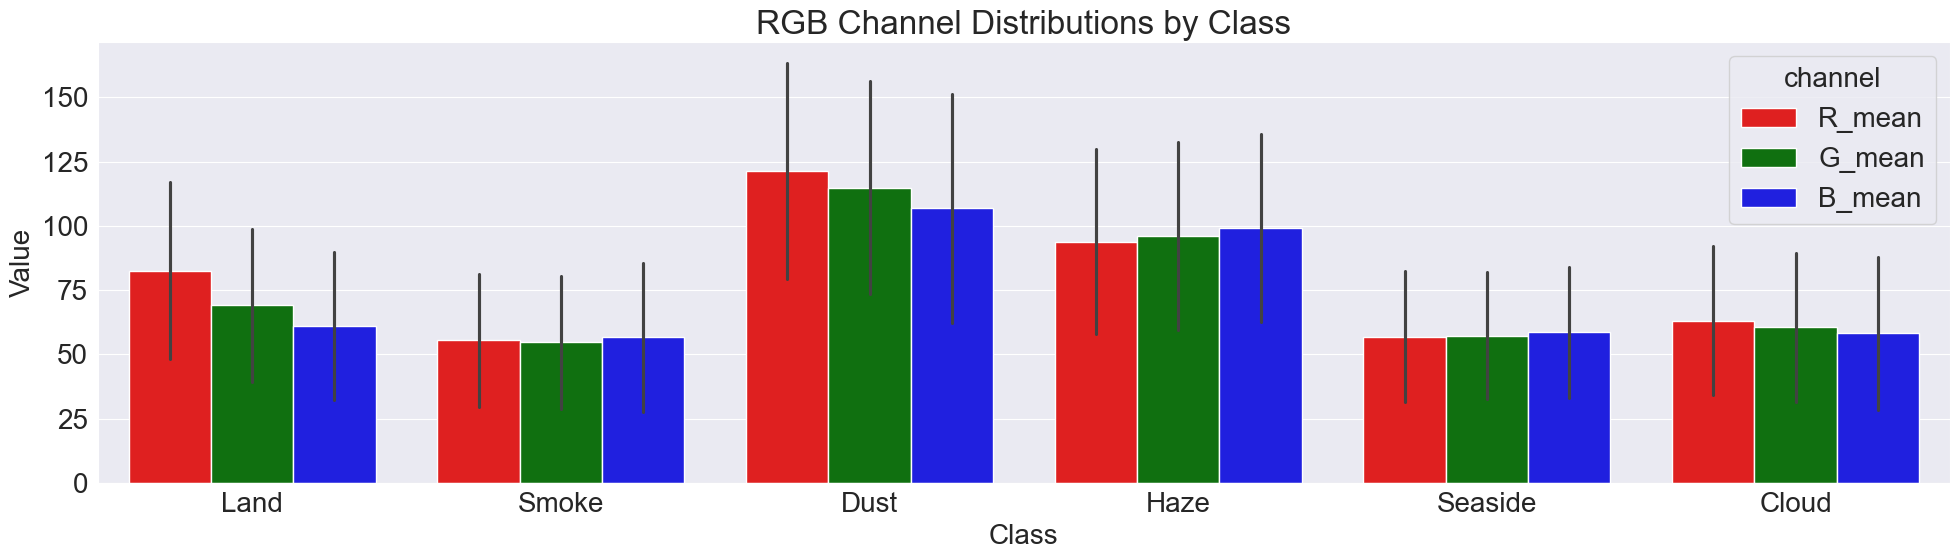

In [4]:
rgb_data = pd.melt(df, 
                   id_vars=['class'], 
                   value_vars=['R_mean', 'G_mean', 'B_mean'],
                   var_name='channel', 
                   value_name='value')

plt.figure(figsize=(20, 6))
sns.barplot(data=rgb_data, x='class', y='value', hue='channel', estimator = 'mean', palette=['r','g','b'], errorbar = 'sd')
plt.title('RGB Channel Distributions by Class')
plt.xlabel('Class')
plt.ylabel('Value')

plt.tight_layout()
plot_output = os.path.join(output_path, 'rgb_channel_distributions.png')
plt.savefig(plot_output)

plt.show()

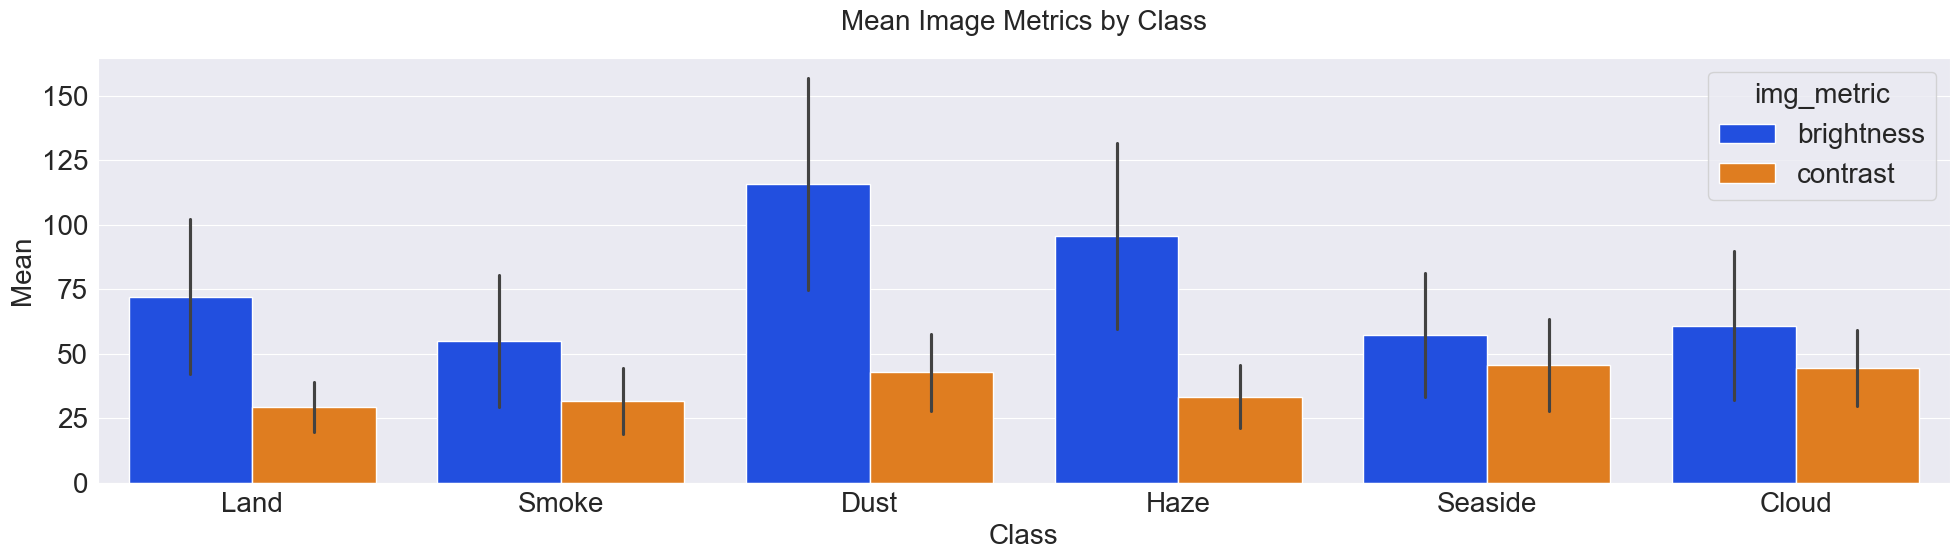

In [5]:
image_metrics = pd.melt(df,
                        id_vars = 'class', 
                        value_vars = ['brightness','contrast'], 
                        var_name = 'img_metric',
                        value_name = 'value')

plt.figure(figsize=(20, 6))
sns.barplot(data=image_metrics, x='class', y='value', hue='img_metric', estimator = 'mean', errorbar = 'sd', palette = 'bright')
plt.title('Mean Image Metrics by Class', fontsize = 20, pad=20)
plt.xlabel('Class', fontsize = 20)
plt.ylabel('Mean', fontsize = 20)

plt.tight_layout()
plot_output = os.path.join(output_path, 'image_metrics_distributions_class.png')
plt.savefig(plot_output)

plt.show()

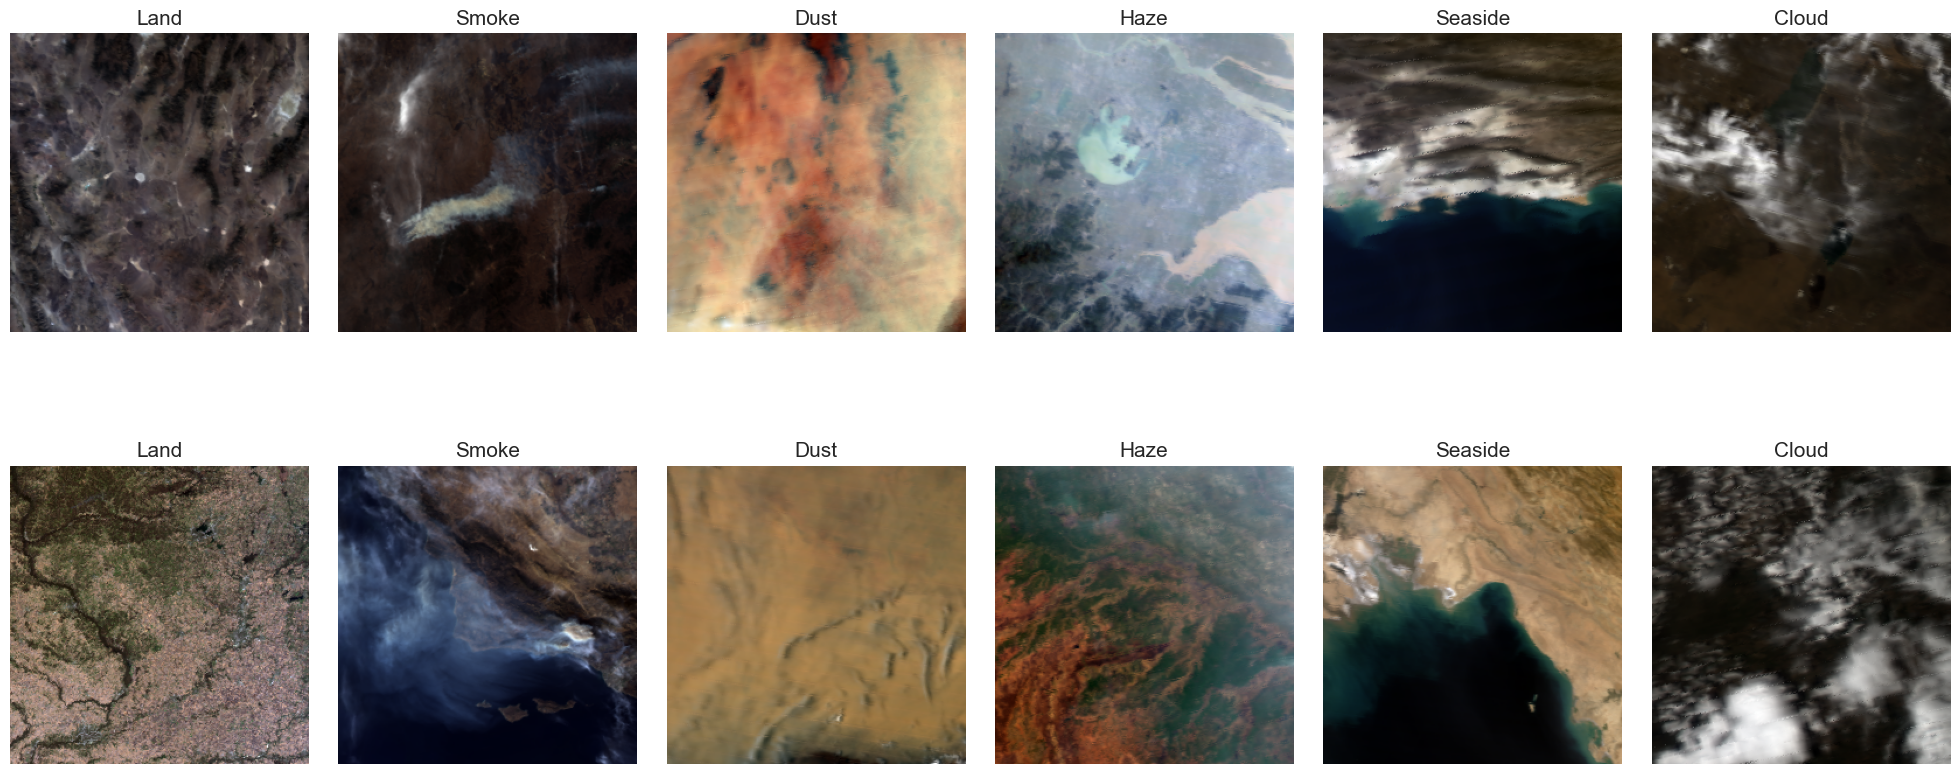

In [6]:
def display_images(df, title='title', samples_per_img=2, seed=1): 
    np.random.seed(seed)
    
    fig, axes = plt.subplots(2, 6, figsize=(20, 10))
    #plt.suptitle(title, size=20)
    
    axes = axes.flatten()
    
    classes = df['class'].unique()
    for idx, img_class in enumerate(classes): 
        class_df = df[df['class'] == img_class]
        random_indices = np.random.choice(class_df.index, 
                                        size=samples_per_img, 
                                        replace=False)
        
        # Plot the images for this class
        for sample_idx in range(samples_per_img):
            ax_idx = idx + (sample_idx * len(classes))  # Calculate correct axis index
            img = class_df.loc[random_indices[sample_idx], 'raw_values']
            
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f'{img_class}', fontsize=15)
            axes[ax_idx].axis('off')
    
    plt.tight_layout()
    
    plot_output = os.path.join(output_path, 'sample_images.png')
    plt.savefig(plot_output)
    
    plt.show()

display_images(df, title='Sample Images from Each Class')

--- BRIGHTNESS OUTLIERS ---
Number of outliers: 12
% of data : 0.1928%

Class distribution: 
class
Dust    10
Land     1
Haze     1
Name: count, dtype: int64



--- CONTRAST OUTLIERS ---
Number of outliers: 21
% of data : 0.3373%

Class distribution: 
class
Seaside    14
Dust        6
Cloud       1
Name: count, dtype: int64


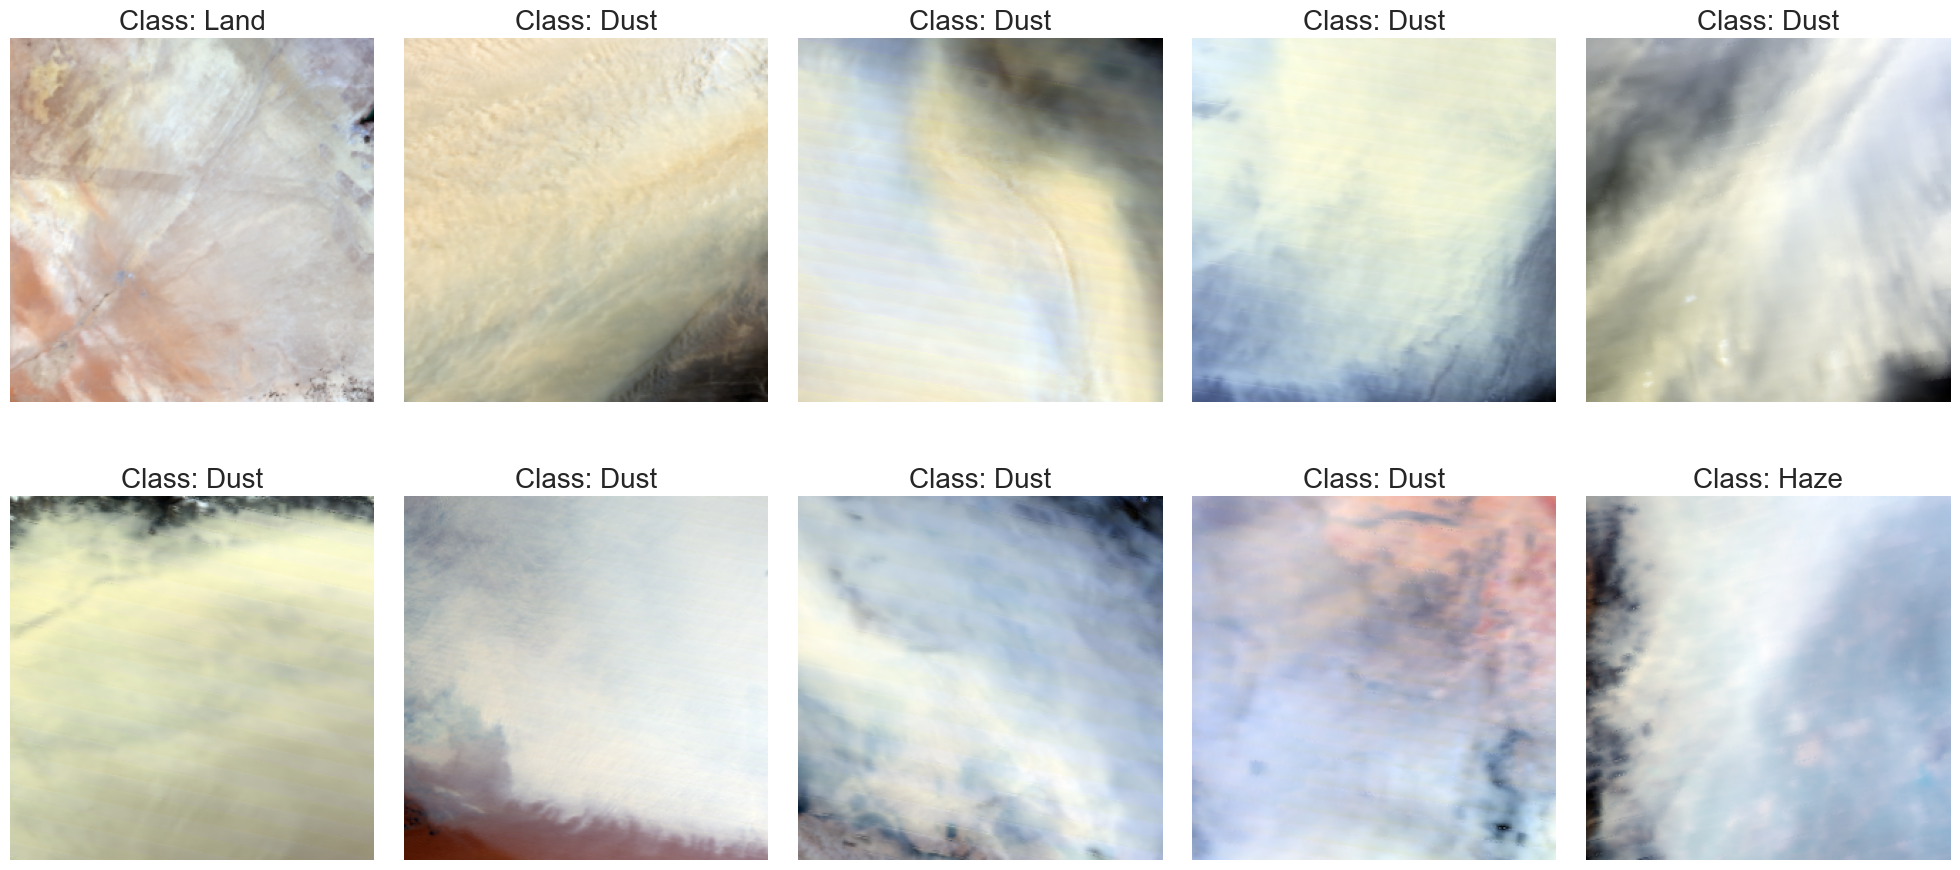

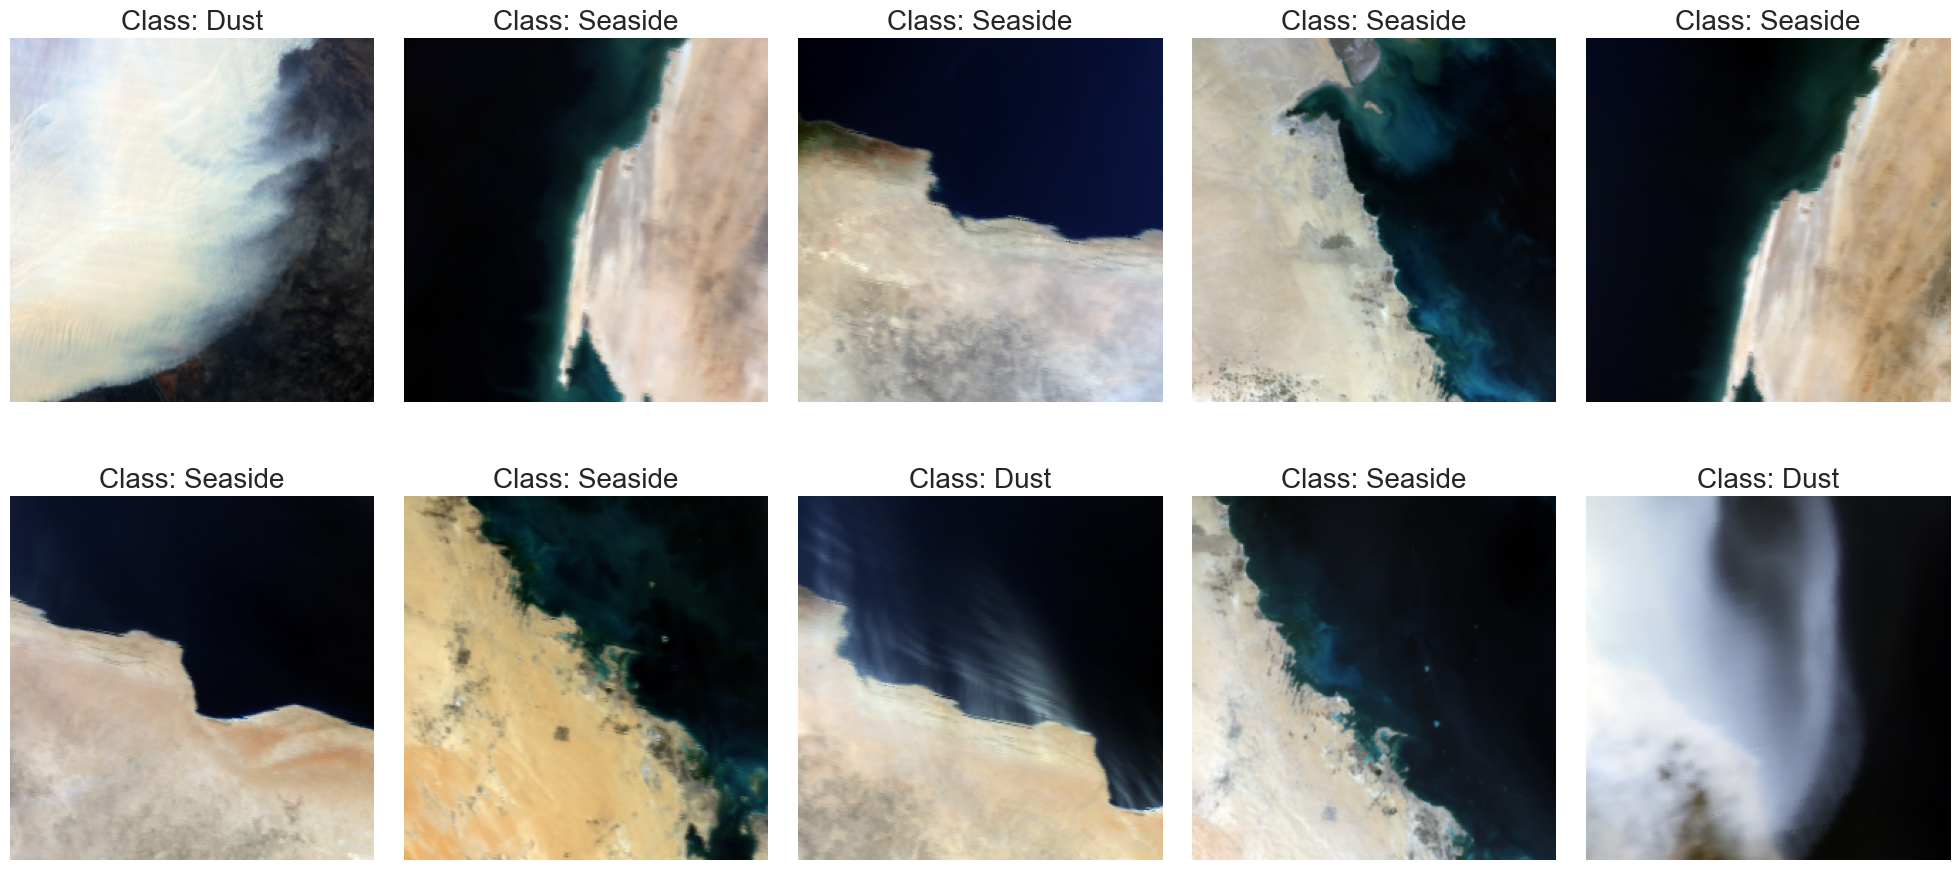

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_metrics = pd.DataFrame(scaler.fit_transform(df[['brightness','contrast']]), 
                              columns = ['s_brightness','s_contrast'], 
                              index = df.index)

outliers_brightness = scaled_metrics[scaled_metrics['s_brightness'].abs() > 3]['s_brightness']
outliers_contrast = scaled_metrics[scaled_metrics['s_contrast'].abs() > 3]['s_contrast']

outliers_brightness = df.iloc[outliers_brightness.index][['raw_values','class']]
outliers_contrast = df.iloc[outliers_contrast.index][['raw_values','class']]

def display_random_outliers(outliers_series, title, n_samples=10):
    random_indices = np.random.choice(range(len(outliers_series)), 
                                    size=min(n_samples, len(outliers_series)), 
                                    replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    #plt.suptitle(title, size=20)
    
    #Flatten for easier indexing
    axes = axes.flatten()
    

    for i, idx in enumerate(random_indices):
        img = outliers_series.values[idx] 
        class_name = df.iloc[outliers_series.index[idx]]['class']
        axes[i].imshow(img)
        axes[i].set_title(f'Class: {class_name}', fontsize = 20)
        axes[i].axis('off')
    
    plt.tight_layout()
    
    plot_output = os.path.join(f'{output_path}, {title}.png')
    plt.savefig(plot_output)
    
    return fig

distribution_brightness = outliers_brightness['class'].value_counts()
distribution_contrast = outliers_contrast['class'].value_counts()


print('--- BRIGHTNESS OUTLIERS ---')
print(f'Number of outliers: {len(outliers_brightness)}')
print(f'% of data : {((len(outliers_brightness) / len(df)) * 100):.4f}%\n')
print(f'Class distribution: \n{distribution_brightness}')

print()
print()
print()

print('--- CONTRAST OUTLIERS ---')
print(f'Number of outliers: {len(outliers_contrast)}')
print(f'% of data : {((len(outliers_contrast) / len(df)) * 100):.4f}%\n')
print(f'Class distribution: \n{distribution_contrast}')

fig1 = display_random_outliers(outliers_brightness['raw_values'], 'Brightness Outliers')
fig2 = display_random_outliers(outliers_contrast['raw_values'], 'Contrast Outliers')

In [13]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

statistics = ['mean','std']
class_stats= df.groupby('class').agg({
    'R_mean' : statistics, 
    'G_mean' : statistics, 
    'B_mean' : statistics, 
    'brightness': statistics, 
    'contrast' : statistics})

features = ['R_mean','G_mean','B_mean','brightness','contrast']
non_significant_pairs = {feature: list() for feature in features}

for feature in features: 
    
    #Create lists with values for each class
    class_values = list()
    for name, group in df.groupby('class'): 
        class_values.append(group[feature].values)

    #ANOVA
    f_stat, p_value = stats.f_oneway(*class_values) #unpacks the items in the list
    print(f'--- ANOVA FOR {feature} ---')
    print(f'p-value: {p_value:.4e}\n')
    
    if p_value < 0.05: 
        tukey = pairwise_tukeyhsd(df[feature], df['class'])
        tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], 
                              columns=tukey._results_table.data[0])
        
        print('--- TUKEY HSD ---')
        print(f'Non-signficant difference in means for {feature}:')
        non_significant = tukey_df[tukey_df['reject'] == False]
        for i, row in non_significant.iterrows(): 
            group1 = row['group1']
            group2 = row['group2']
            pval = row['p-adj']
            
            print(f'{group1} and {group2} (pval = {pval:.4f})')
            non_significant_pairs[feature].append({
                'pair': (group1, group2),
                'p_value': pval
            })
            
        print()
        print()
        

--- ANOVA FOR R_mean ---
p-value: 0.0000e+00

--- TUKEY HSD ---
Non-signficant difference in means for R_mean:
Seaside and Smoke (pval = 0.9119)


--- ANOVA FOR G_mean ---
p-value: 0.0000e+00

--- TUKEY HSD ---
Non-signficant difference in means for G_mean:
Cloud and Seaside (pval = 0.1654)
Seaside and Smoke (pval = 0.4738)


--- ANOVA FOR B_mean ---
p-value: 0.0000e+00

--- TUKEY HSD ---
Non-signficant difference in means for B_mean:
Cloud and Land (pval = 0.3586)
Cloud and Seaside (pval = 0.9999)
Cloud and Smoke (pval = 0.8310)
Land and Seaside (pval = 0.5536)
Seaside and Smoke (pval = 0.7232)


--- ANOVA FOR brightness ---
p-value: 0.0000e+00

--- TUKEY HSD ---
Non-signficant difference in means for brightness:
Cloud and Seaside (pval = 0.0687)
Seaside and Smoke (pval = 0.6372)


--- ANOVA FOR contrast ---
p-value: 1.5744e-268

--- TUKEY HSD ---
Non-signficant difference in means for contrast:
Cloud and Seaside (pval = 0.5649)
Haze and Smoke (pval = 0.1138)




In [9]:
for feature, pairs in non_significant_pairs.items():
    if pairs:  # if there are any non-significant pairs for this feature
        print(f"\nFeature: {feature}")
        for pair_info in pairs:
            print(f"Classes {pair_info['pair']} are similar (p={pair_info['p_value']:.4f})")


Feature: R_mean
Classes ('Seaside', 'Smoke') are similar (p=0.9119)

Feature: G_mean
Classes ('Cloud', 'Seaside') are similar (p=0.1654)
Classes ('Seaside', 'Smoke') are similar (p=0.4738)

Feature: B_mean
Classes ('Cloud', 'Land') are similar (p=0.3586)
Classes ('Cloud', 'Seaside') are similar (p=0.9999)
Classes ('Cloud', 'Smoke') are similar (p=0.8310)
Classes ('Land', 'Seaside') are similar (p=0.5536)
Classes ('Seaside', 'Smoke') are similar (p=0.7232)

Feature: brightness
Classes ('Cloud', 'Seaside') are similar (p=0.0687)
Classes ('Seaside', 'Smoke') are similar (p=0.6372)

Feature: contrast
Classes ('Cloud', 'Seaside') are similar (p=0.5649)
Classes ('Haze', 'Smoke') are similar (p=0.1138)


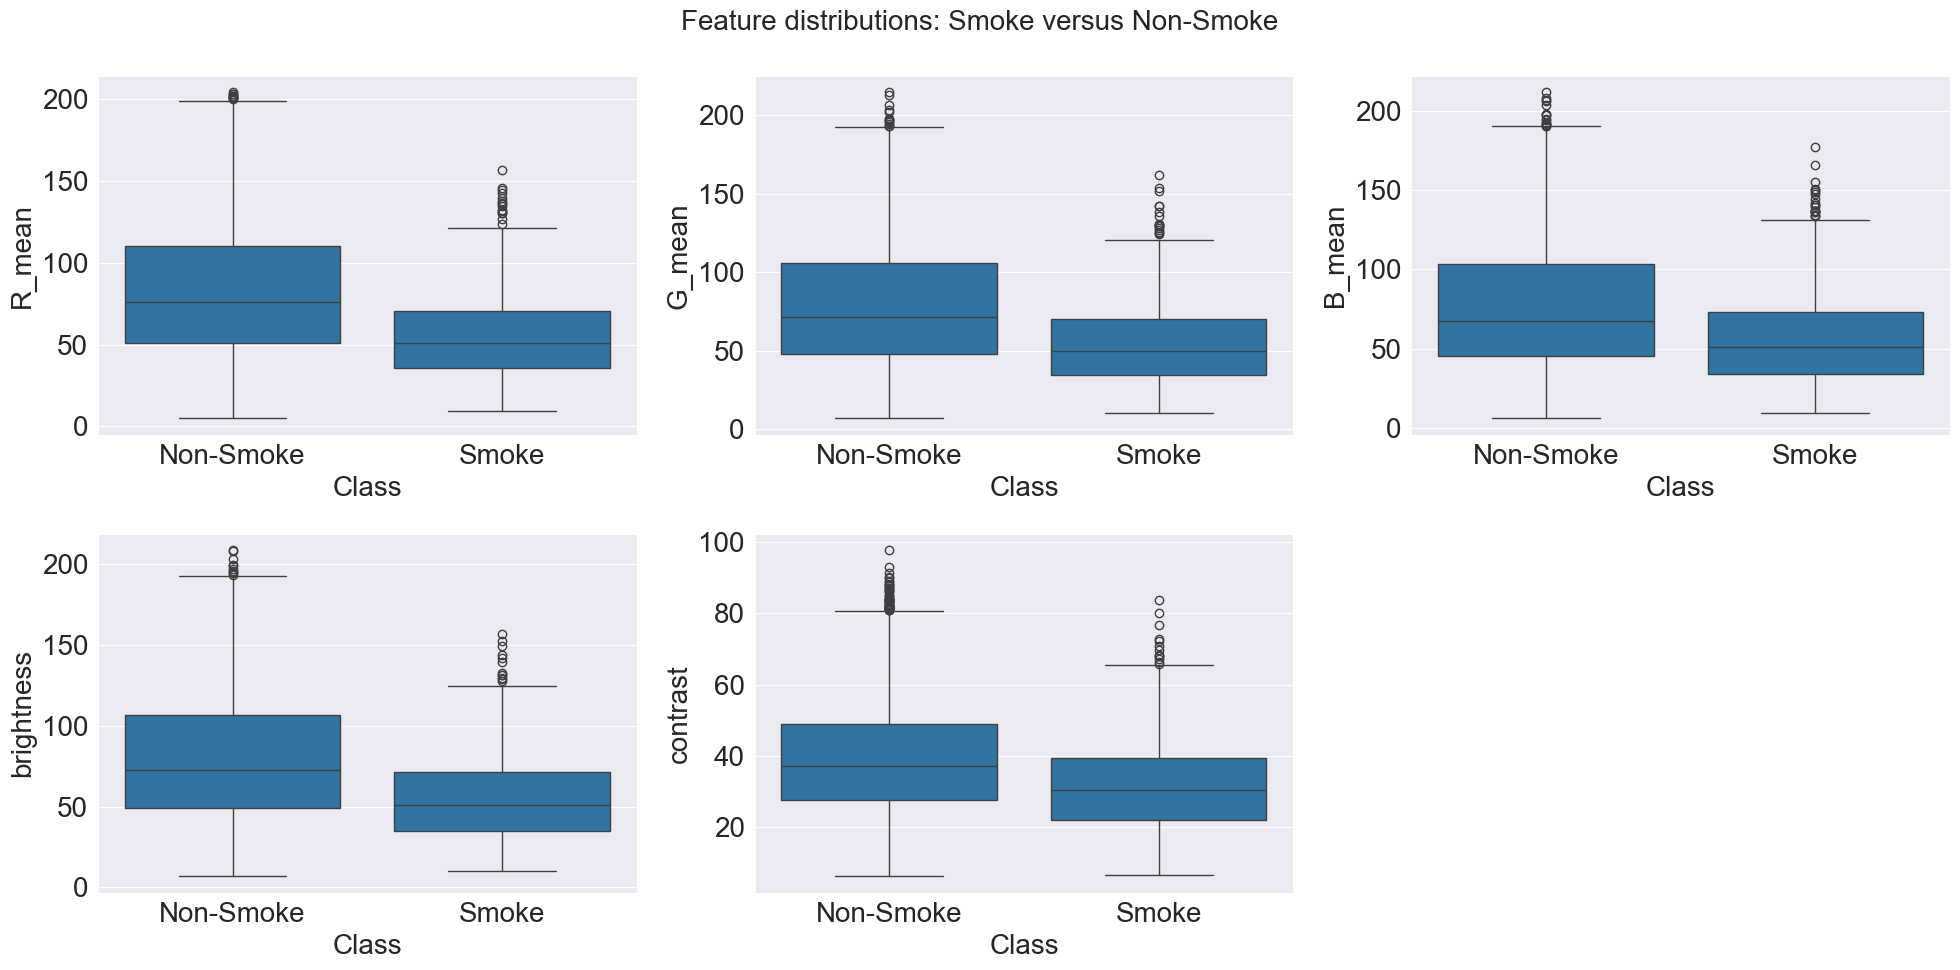

In [10]:
smoke_df = df.drop('raw_values', axis = 1)
smoke_df['binary_class'] = smoke_df['class'].apply(lambda x: 'Smoke' if x == 'Smoke' else 'Non-Smoke')

features = ['R_mean','G_mean','B_mean','brightness','contrast']

fig, axes = plt.subplots(2, 3, figsize = (20,10))
axes = axes.flatten()
for i, feature in enumerate(features): 
    sns.boxplot(x = 'binary_class', y = feature, data = smoke_df, ax= axes[i]).set_xlabel('Class', size = 20)
fig.delaxes(axes[len(axes) -1])

fig.suptitle('Feature distributions: Smoke versus Non-Smoke', size = 20)

plt.tight_layout()

plot_output = os.path.join(output_path, 'smoke_nonsmoke_distributions.png')
plt.savefig(plot_output)

plt.show()

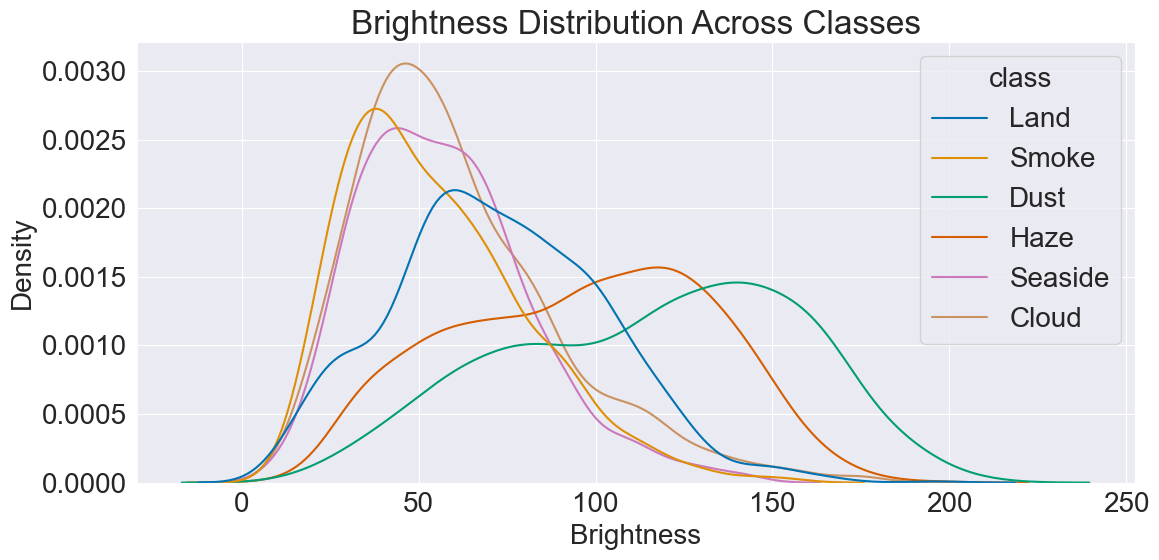

In [11]:
plt.figure(figsize=(12,6))
sns.kdeplot(x = 'brightness' , data = df, hue = 'class' ,palette = 'colorblind', legend = True)
plt.xlabel('Brightness')
plt.title('Brightness Distribution Across Classes')
plt.tight_layout()

plot_output = os.path.join(output_path, 'brightness_distributions_classes.png')
plt.savefig(plot_output)

plt.show()

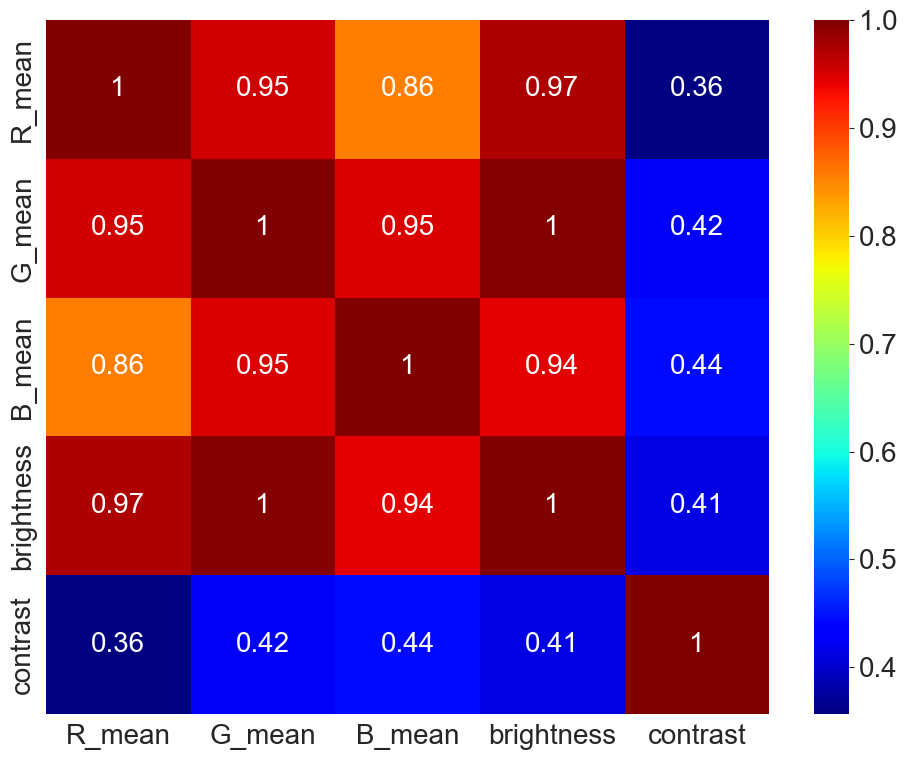

In [12]:
plt.figure(figsize= (10, 8))
sns.heatmap(df.corr(numeric_only= True), annot = True, cmap = 'jet')
plt.tight_layout()

plot_output = os.path.join(output_path, 'heatmap_corrs.png')
plt.savefig(plot_output)

plt.show()